In [1]:
import numpy as np

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import torchvision

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.contrib import autoguide
from pyro.infer.mcmc import MCMC, NUTS

import math
import random
import itertools
import matplotlib.pyplot as plt

In [2]:
def datagen(wfreq, A, n):
    t = 0
    while True:
        yield random.normalvariate(A * math.sin(t), n)
        t += wfreq

def batch_datagen(gen, batch_size):
    while True:
        yield torch.tensor(list(itertools.islice(gen, batch_size)), dtype=torch.double).reshape(-1, 1)

In [3]:
def symmetrize(M):
    return 0.5 * (M + M.t())

In [4]:
def apply_kalman(zF, xH, zQ, xQ, xs, z0, z0_cov):
    z = z0
    z_cov = z0_cov
    
    z_len = z0.shape[-1]
    x_len = xs.shape[-1]

    z_pri_hist = []
    z_cov_pri_hist = []
    z_post_hist = []
    z_cov_post_hist = []
    for i in range(xs.shape[-2]):
        z_prior = zF @ z
        z_prior_cov = symmetrize(zF @ z_cov @ zF.t() + zQ)
        
        y = xs[i] - xH @ z_prior
        y_cov = symmetrize(xH @ z_prior_cov @ xH.t() + xQ)
        gain = z_prior_cov @ xH.t() @ torch.inverse(y_cov)
        
        z_post = z_prior + gain @ y
        #z_post_cov = symmetrize( (torch.eye(z_len, dtype=torch.double) - gain @ xH) @ z_prior_cov @ (torch.eye(z_len, dtype=torch.double) - gain @ xH).t() + gain @ xQ @ gain.t() )
        z_post_cov = symmetrize( ( torch.eye(z_len, dtype=torch.double) - gain @ xH ) @ z_prior_cov )
        
        z = z_post
        z_cov = z_post_cov
        
        z_pri_hist.append(z_prior)
        z_cov_pri_hist.append(z_prior_cov)
        z_post_hist.append(z_post)
        z_cov_post_hist.append(z_post_cov)
    
    ret = {
        'z_pri' : torch.stack(z_pri_hist ), 'z_pri_cov' : torch.stack(z_cov_pri_hist),
        'z_post': torch.stack(z_post_hist), 'z_post_cov': torch.stack(z_cov_post_hist)
    }
    ret['x_pri'] = (xH @ ret['z_pri'][...,None])[...,0]
    ret['x_pri_cov'] = xH @ ret['z_pri_cov'] @ xH.t() + xQ
    ret['x_post'] = (xH @ ret['z_post'][...,None])[...,0]
    ret['x_post_cov'] = xH @ ret['z_post_cov'] @ xH.t() + xQ
    return ret
    

In [5]:
def model(xs, z0, z0_cov, zs_out=None, online=False):
    z_len = z0.shape[-1]
    x_len = xs.shape[-1]

    zF = pyro.sample('zF', dist.Normal(torch.zeros(z_len, z_len, dtype=torch.double), 1 * torch.ones(z_len, z_len, dtype=torch.double)).to_event(2))
    xH = pyro.sample('xH', dist.Normal(torch.zeros(x_len, z_len, dtype=torch.double), 1 * torch.ones(x_len, z_len, dtype=torch.double)).to_event(2))
    #xH = torch.eye(x_len, z_len, dtype=torch.double)
    
    #zQ = pyro.sample('zQ', dist.Normal(torch.zeros(z_len, z_len), 1000 * torch.ones(z_len, z_len)).to_event(2))
    #xQ = pyro.sample('xQ', dist.Normal(torch.zeros(x_len, x_len), 1000 * torch.ones(x_len, x_len)).to_event(2))
    zQ = torch.diag(pyro.sample('zQ', dist.HalfNormal(1000 * torch.ones(z_len, dtype=torch.double)).to_event(1)) + 1e-4)
    xQ = torch.diag(pyro.sample('xQ', dist.HalfNormal(1000 * torch.ones(x_len, dtype=torch.double)).to_event(1)) + 1e-4)
    
    kf_res = apply_kalman(zF, xH, zQ, xQ, xs, z0, z0_cov)
    for i in range(len(xs)):
        pyro.sample('x_{}'.format(i), dist.MultivariateNormal(kf_res['x_pri'][i], kf_res['x_pri_cov'][i]), obs=xs[i])
    
    if zs_out is not None:
        if online:
            zs_out['z']     = kf_res['z_post'][-1]#.detach()
            zs_out['z_cov'] = kf_res['z_post_cov'][-1]#.detach()
        zs_out['x_all'] = kf_res['x_post']#.detach()
        zs_out['x_in']  = xs


In [6]:
if False: #That thing would be useful, but it's waay too slow
    pyro.enable_validation(False)
    nuts_kernel = NUTS(model)
    mcmc_run = MCMC(nuts_kernel, num_samples=400, warmup_steps=200).run(
    data, torch.tensor([1, 0], dtype=torch.double), torch.eye(2, dtype=torch.double))
    #plt.hist(mcmc_run.marginal('xH').empirical['xH']._samples.numpy())

In [7]:
class Averager:
    def __init__(self, alpha=0.98):
        self.alpha = alpha
        self.sum = 0
        self.x = 0
    
    def __call__(self, x):
        self.x = self.alpha * self.x + (1 - self.alpha) * x
        self.sum = self.alpha * self.sum + (1 - self.alpha)
        return self.x / self.sum

Step     0 Loss 621.032
Step    50 Loss 185.729
Step   100 Loss 159.853
Step   150 Loss 147.916
Step   200 Loss 135.905
Step   250 Loss 131.318
Step   300 Loss 129.468
Step   350 Loss 128.611
Step   400 Loss 128.114
Step   450 Loss 127.741
Step   500 Loss 127.411
Step   550 Loss 127.102
Step   600 Loss 126.780
Step   650 Loss 126.460
Step   700 Loss 126.129
Step   750 Loss 125.799


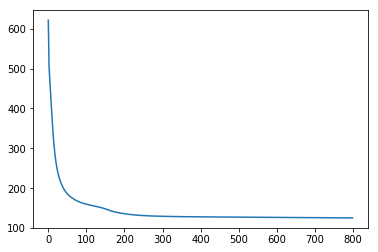

In [8]:
guide = autoguide.AutoDelta(model)

pyro.clear_param_store()
pyro.enable_validation(True)

#trace = pyro.poutine.trace(guide).get_trace(train_data.reshape(-1, 100, 28 * 28))
#trace.compute_log_prob()
#print(trace.format_shapes())

online = False

zs = {
    'z': torch.tensor([1, 0], dtype=torch.double),
    'z_cov': torch.eye(2, dtype=torch.double)
}
batch_size = 100
data_source = batch_datagen(datagen(0.2, 1, 0.6), batch_size)
data = next(data_source)

losses = []
loss_avg = Averager()
def train_loop(optimizer, optimizer_kwargs, iter_count, sm_start=2.0, sm_end=0.0):
    global data, zs
    iter_start = len(losses)
    tr = pyro.poutine.trace(guide).get_trace(data, zs['z'], zs['z_cov'], zs_out=zs, online=online)
    elbo = pyro.infer.Trace_ELBO()
    params = {pyro.param(name).unconstrained()
              for name in pyro.get_param_store().get_all_param_names()}
    opt = optimizer(params, **optimizer_kwargs)
    try:
        smflt = torch.tensor([[[1, -3, 3, -1]]], dtype=torch.double)
        for step in range(iter_start, iter_count + iter_start):
            sm = sm_start + (sm_end - sm_start) * (step - iter_start) / (iter_count - 1)
            def closure():
                global zs
                zs = {name: zs[name].detach() if zs[name].grad_fn is not None else zs[name] for name in zs}
                opt.zero_grad()
                loss = elbo.differentiable_loss(model, guide, data, zs['z'], zs['z_cov'], zs_out=zs, online=online)
                loss = loss + sm * (F.conv1d(zs['x_all'].t()[:,None,:], smflt) ** 2).mean() ** 0.5
                loss = loss.reshape(1)
                loss.backward()
                return loss
            losses.append(loss_avg( opt.step(closure).item() ))
            if step % 50 == 0:
                print('Step {:>5d} Loss {:.3f}'.format(step, losses[-1]))
        if online:
            data = next(data_source)
    except KeyboardInterrupt:
        pass

#train_loop(torch.optim.Adadelta, {'lr': 100.0}, 200)
#train_loop(torch.optim.Adam    , {'lr': 0.03} , 1000)
train_loop(torch.optim.SdLBFGS, {'lr': 2.0}, 800, 20.0, 0.0)

plt.plot(losses)

In [9]:
params = dict(pyro.get_param_store())
params = {k: params[k].clone().detach() for k in params}

In [10]:
zF = params['auto_zF']
xH = params['auto_xH']
#xH = torch.eye(1, 2, dtype=torch.double)
zQ = torch.diag(params['auto_zQ'] + 1e-4)
xQ = torch.diag(params['auto_xQ'] + 1e-4)
z0 = zs['z']
z0_cov  = zs['z_cov']
pred = apply_kalman(zF, xH, zQ, xQ, data, z0, z0_cov)

In [11]:
zF, xH, zQ, xQ, z0, z0_cov

(tensor([[ 0.9849,  0.2029],
         [-0.1962,  0.9752]], dtype=torch.float64),
 tensor([[-0.0059,  0.0067]], dtype=torch.float64),
 tensor([[1.8009e+02, 0.0000e+00],
         [0.0000e+00, 5.9057e-03]], dtype=torch.float64),
 tensor([[0.3390]], dtype=torch.float64),
 tensor([1., 0.], dtype=torch.float64),
 tensor([[1., 0.],
         [0., 1.]], dtype=torch.float64))

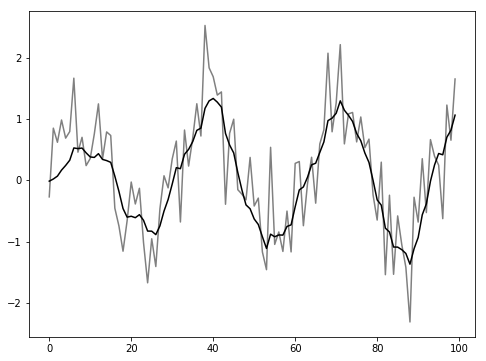

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(data.numpy(), color='gray')
plt.plot(pred['x_post'].detach().numpy(), color='black')
#plt.plot(pred['z_post'].detach().numpy()[:,0], color='black')
#plt.plot(pred['z_post'].detach().numpy()[:,1], color='green')
#plt.plot(pred['x'].numpy() + pred['x_cov'].numpy()[...,0] ** 0.5)

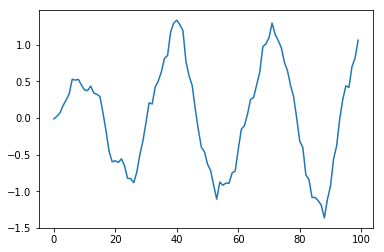

In [13]:
plt.plot(pred['x_post'].detach().numpy())

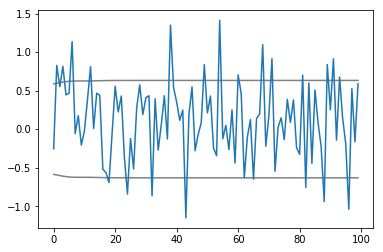

In [14]:
plt.plot( pred['x_post_cov'].detach().sqrt()[...,0].numpy(), color='gray')
plt.plot(-pred['x_post_cov'].detach().sqrt()[...,0].numpy(), color='gray')
plt.plot(data.numpy() - pred['x_post'].detach().numpy())
